<a href="https://colab.research.google.com/github/chi-hun/dacon/blob/main/%EC%9C%A0%EB%B0%A9%EC%95%94%EC%9D%98_%EC%9E%84%ED%8C%8C%EC%84%A0_%EC%A0%84%EC%9D%B4_%EC%98%88%EC%B8%A1_AI%EA%B2%BD%EC%A7%84%EB%8C%80%ED%9A%8C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

유방암의 임파선 전이 예측 AI경진대회
https://dacon.io/competitions/official/236011/overview/description

# module

In [165]:
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 76.8 MB 14 kB/s 


In [203]:
import os
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBRFClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
import albumentations as A
import tensorflow as tf
from tensorflow.keras import layers

# data load

In [130]:
!unzip '/content/drive/MyDrive/Colab Notebooks/데이콘/유방암의 임파선 전이 예측 AI경진대회/train_1.zip'
!unzip '/content/drive/MyDrive/Colab Notebooks/데이콘/유방암의 임파선 전이 예측 AI경진대회/train_mask_1.zip'

Archive:  /content/drive/MyDrive/Colab Notebooks/데이콘/유방암의 임파선 전이 예측 AI경진대회/train_1.zip
replace train/BC_01_0001.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: N
Archive:  /content/drive/MyDrive/Colab Notebooks/데이콘/유방암의 임파선 전이 예측 AI경진대회/train_mask_1.zip
replace train_mask/BC_01_0015.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [131]:
train_path = sorted(glob.glob('/content/train/*.png'))
train_mask_path = sorted(glob.glob('/content/train_mask/*.png'))

In [172]:
train_csv = pd.read_csv('/content/train.csv')

In [173]:
for i, path in enumerate(train_path):
    id = path.split('/')[-1].split('.')[0]
    assert train_csv.iloc[i]['ID'] == id
    train_csv.loc[i, 'img_path'] = path
for path in train_mask_path:
    mask = path.split('/')[-1].split('.')[0]
    train_csv.loc[train_csv['ID'] == mask, 'mask_path'] = path

# EDA

In [14]:
train_csv.head()

,ID,img_path,mask_path,나이,수술연월일,진단명,암의 위치,암의 개수,암의 장경,NG,...,ER_Allred_score,PR,PR_Allred_score,KI-67_LI_percent,HER2,HER2_IHC,HER2_SISH,HER2_SISH_ratio,BRCA_mutation,N_category
0,BC_01_0001,/content/train/BC_01_0001.png,-,63,2015-10-23,1,2,1,19.0,2.0,...,8.0,1.0,6.0,12.0,0.0,1.0,NaN,NaN,NaN,0
1,BC_01_0002,/content/train/BC_01_0002.png,-,51,2015-10-28,1,1,1,22.0,3.0,...,NaN,0.0,NaN,70.0,0.0,0.0,NaN,NaN,NaN,1
2,BC_01_0003,/content/train/BC_01_0003.png,-,37,2015-10-29,1,2,1,NaN,2.0,...,7.0,1.0,4.0,7.0,0.0,1.0,NaN,NaN,0.0,0
3,BC_01_0004,/content/train/BC_01_0004.png,-,54,2016-03-08,1,2,1,0.0,3.0,...,NaN,0.0,NaN,1.0,1.0,3.0,NaN,NaN,NaN,0
4,BC_01_0005,/content/train/BC_01_0005.png,-,57,2015-10-30,1,2,1,8.0,2.0,...,8.0,0.0,NaN,8.0,1.0,2.0,1.0,5.44,NaN,0


In [15]:
train_csv_mask = train_csv[train_csv['mask_path'] != '-']

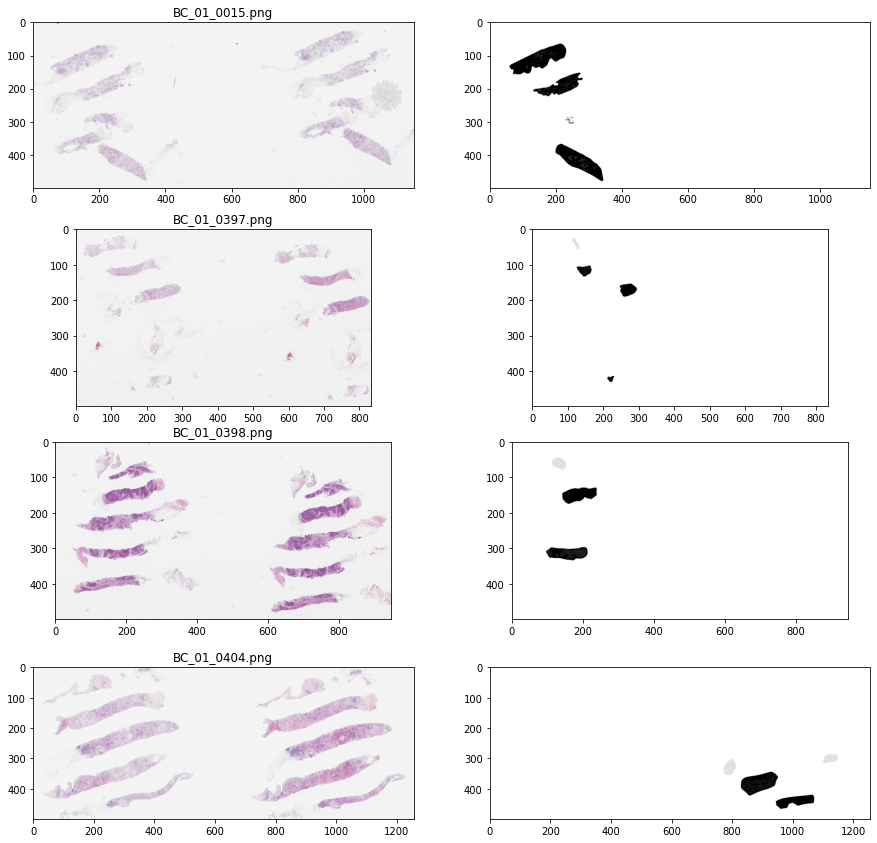

In [54]:
plt.figure(figsize=(15,15))
for i in range(4):
    plt.subplot(4,2,i*2+1)
    plt.title(train_csv_mask['img_path'].values[i].split('/')[-1])
    img = cv2.imread(train_csv_mask['img_path'].values[i])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.subplot(4,2,i*2+2)
    img_m = cv2.imread(train_csv_mask['mask_path'].values[i])
    img_m = cv2.cvtColor(img_m, cv2.COLOR_BGR2RGB)
    plt.imshow(img_m)
plt.show()

In [ ]:
train_csv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 28 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   ID                 1000 non-null   object 
 1   img_path           1000 non-null   object 
 2   mask_path          1000 non-null   object 
 3   나이                 1000 non-null   int64  
 4   수술연월일              1000 non-null   object 
 5   진단명                1000 non-null   int64  
 6   암의 위치              1000 non-null   int64  
 7   암의 개수              1000 non-null   int64  
 8   암의 장경              931 non-null    float64
 9   NG                 949 non-null    float64
 10  HG                 914 non-null    float64
 11  HG_score_1         908 non-null    float64
 12  HG_score_2         908 non-null    float64
 13  HG_score_3         911 non-null    float64
 14  DCIS_or_LCIS_여부    1000 non-null   int64  
 15  DCIS_or_LCIS_type  126 non-null    float64
 16  T_category         996 no

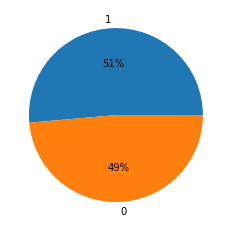

In [ ]:
plt.pie(train_csv['N_category'].value_counts().values, labels=train_csv['N_category'].value_counts().index, autopct='%.0f%%')
plt.show()

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 45208 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51060 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 45208 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 51060 missing from current font.
  font.set_text(s, 0, flags=flags)


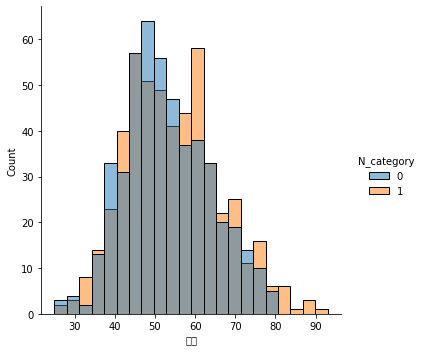

In [ ]:
sns.displot(data=train_csv, x='나이', hue='N_category',)
plt.show()

In [19]:
train_csv['수술연월일'].max(), train_csv['수술연월일'].min()

('2020-06-30', '2006-09-22')

In [20]:
train_csv['수술연월일'] = pd.to_datetime(train_csv['수술연월일'])

In [36]:
(pd.to_datetime('2020-10-01') - train_csv['수술연월일'][0]).days // 30

60

In [49]:
def deltamonth(x):
    return (pd.to_datetime('2020-07-01') - x).days // 365
train_csv['수술경과년'] = train_csv['수술연월일'].apply(deltamonth)

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49688 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49696 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 44221 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 44284 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 45380 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 49688 missing from current font.
  font.set_

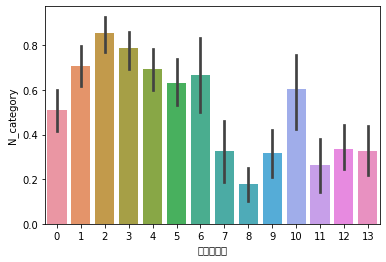

In [51]:
sns.barplot(data=train_csv, x='수술경과년', y='N_category')
plt.show()

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49688 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49696 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 44221 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 44284 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 50900 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 49688 missing from current font.
  font.set_

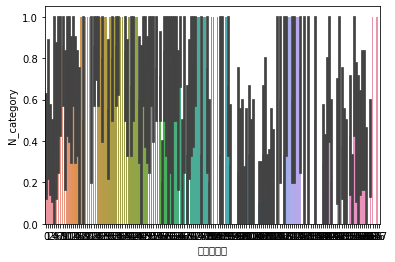

In [52]:
sns.barplot(data=train_csv, x='수술경과월', y='N_category')
plt.show()

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51652 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 45800 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 47749 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 51652 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 45800 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 47749 missing from current font.
  font.set_text

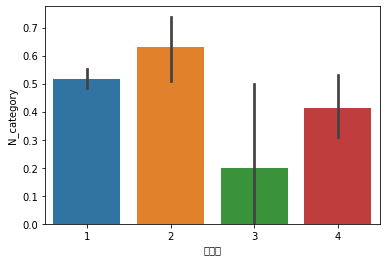

In [ ]:
sns.barplot(data=train_csv, x='진단명', y='N_category')
plt.show()

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 50516 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51032 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 50948 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 52824 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 50516 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 51032 missing from current font.
  font.set_te

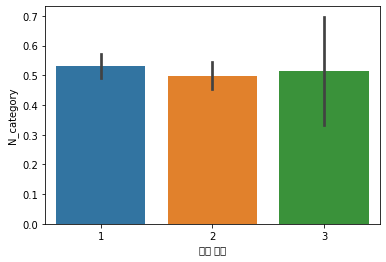

In [56]:
sns.barplot(data=train_csv, x='암의 위치', y='N_category')
plt.show()

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 50516 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51032 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 44060 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49688 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 50516 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 51032 missing from current font.
  font.set_te

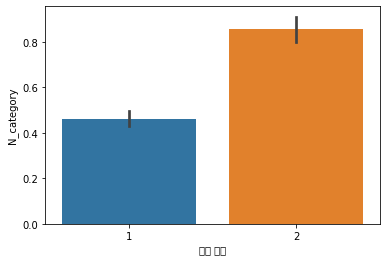

In [57]:
sns.barplot(data=train_csv, x='암의 개수', y='N_category')
plt.show()

In [63]:
train_csv['암의 장경'] = pd.cut(train_csv['암의 장경'],bins=10, labels=range(10))

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 50516 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51032 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51109 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 44221 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 50516 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 51032 missing from current font.
  font.set_te

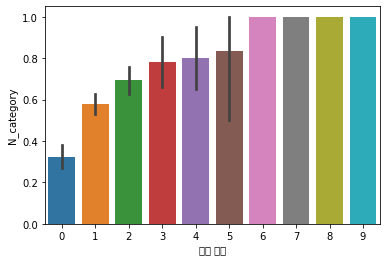

In [64]:
sns.barplot(data=train_csv, x='암의 장경', y='N_category')
plt.show()

In [68]:
train_csv[train_csv['암의 장경'].isna()]['N_category'].value_counts()

0    65
1     4
Name: N_category, dtype: int64

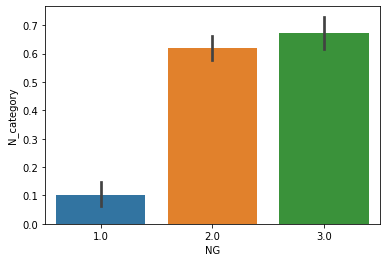

In [69]:
sns.barplot(data=train_csv, x='NG', y='N_category')
plt.show()

In [70]:
train_csv[train_csv['NG'].isna()]['N_category'].value_counts()

0    38
1    13
Name: N_category, dtype: int64

In [75]:
train_csv['HG'].fillna(0, inplace=True)

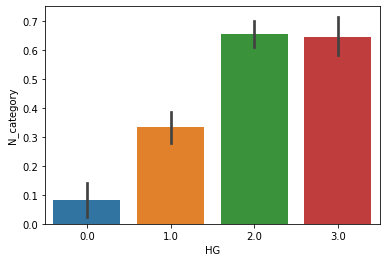

In [76]:
sns.barplot(data=train_csv, x='HG', y='N_category')
plt.show()

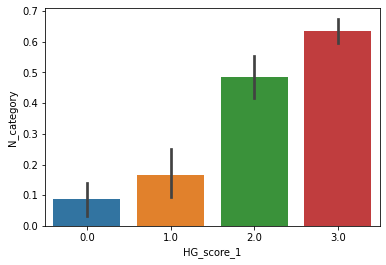

In [78]:
train_csv['HG_score_1'].fillna(0, inplace=True)
sns.barplot(data=train_csv, x='HG_score_1', y='N_category')
plt.show()

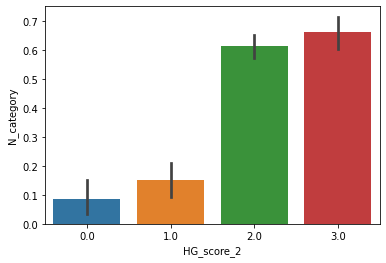

In [80]:
train_csv['HG_score_2'].fillna(0, inplace=True)
sns.barplot(data=train_csv, x='HG_score_2', y='N_category')
plt.show()

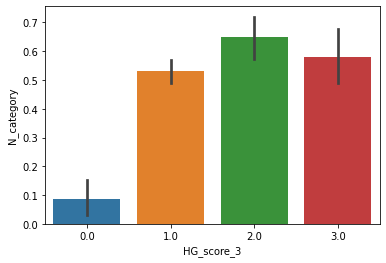

In [84]:
train_csv['HG_score_3'].fillna(0, inplace=True)
train_csv.loc[train_csv['HG_score_3'] == 4, 'HG_score_3'] = 0
sns.barplot(data=train_csv, x='HG_score_3', y='N_category')
plt.show()

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 50668 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 48512 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 50668 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 48512 missing from current font.
  font.set_text(s, 0, flags=flags)


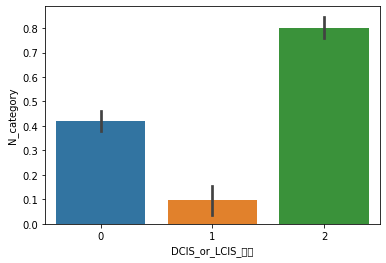

In [85]:
sns.barplot(data=train_csv, x='DCIS_or_LCIS_여부', y='N_category')
plt.show()

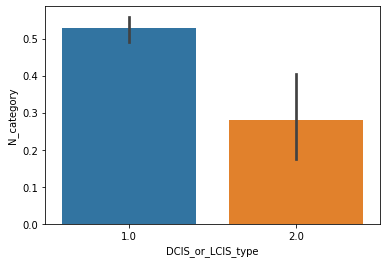

In [87]:
train_csv['DCIS_or_LCIS_type'].fillna(1.0, inplace=True)
sns.barplot(data=train_csv, x='DCIS_or_LCIS_type', y='N_category')
plt.show()

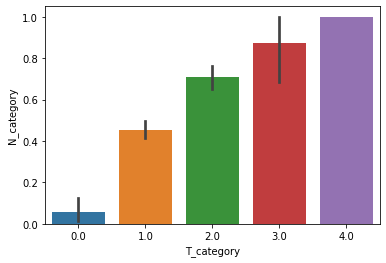

In [88]:
sns.barplot(data=train_csv, x='T_category', y='N_category')
plt.show()

In [89]:
train_csv[train_csv['T_category'].isna()]['N_category'].value_counts()

1    4
Name: N_category, dtype: int64

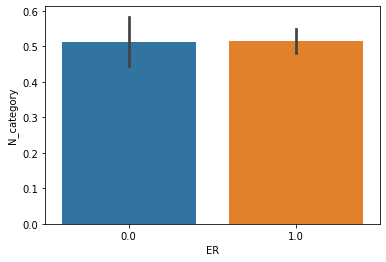

In [92]:
sns.barplot(data=train_csv, x='ER', y='N_category')
plt.show()

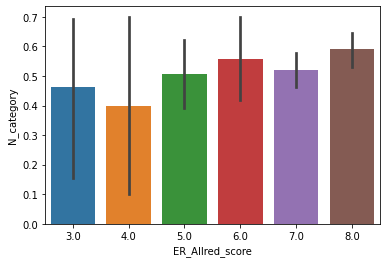

In [93]:
sns.barplot(data=train_csv, x='ER_Allred_score', y='N_category')
plt.show()

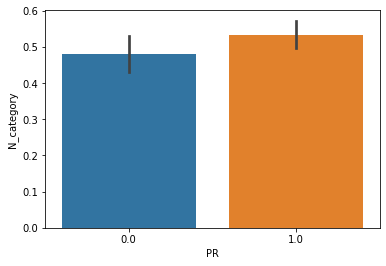

In [94]:
sns.barplot(data=train_csv, x='PR', y='N_category')
plt.show()

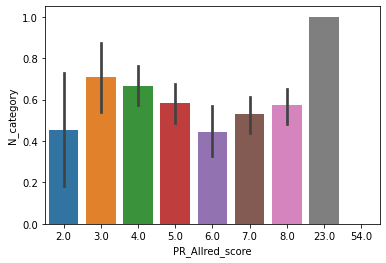

In [95]:
sns.barplot(data=train_csv, x='PR_Allred_score', y='N_category')
plt.show()

In [96]:
train_csv['PR_Allred_score'].value_counts()

8.0     124
7.0     121
5.0      99
4.0      96
6.0      70
3.0      24
2.0      11
23.0      1
54.0      1
Name: PR_Allred_score, dtype: int64

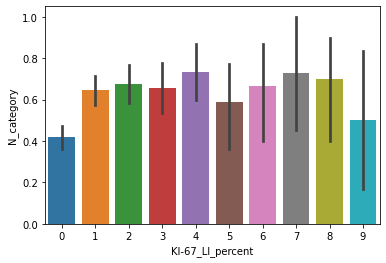

In [98]:
train_csv['KI-67_LI_percent'] = pd.cut(train_csv['KI-67_LI_percent'], bins=10, labels=range(10))
sns.barplot(data=train_csv, x='KI-67_LI_percent', y='N_category')
plt.show()

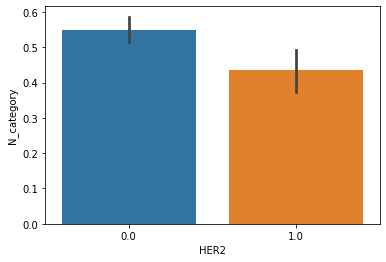

In [99]:
sns.barplot(data=train_csv, x='HER2', y='N_category')
plt.show()

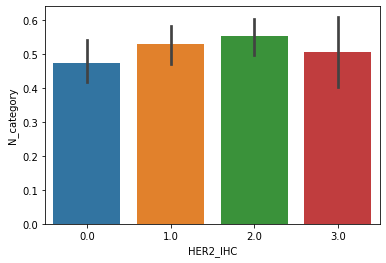

In [100]:
sns.barplot(data=train_csv, x='HER2_IHC', y='N_category')
plt.show()

In [102]:
train_csv[train_csv['HER2'].isna()]['N_category'].value_counts()

0    13
1     1
Name: N_category, dtype: int64

In [105]:
train_csv[train_csv['HER2_IHC'] == 0]['HER2'].value_counts()

0.0    251
Name: HER2, dtype: int64

In [106]:
train_csv[train_csv['HER2_IHC'].isna()]['N_category'].value_counts()

0    18
1     6
Name: N_category, dtype: int64

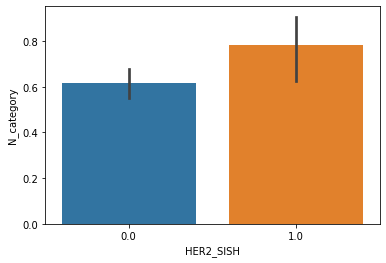

In [107]:
sns.barplot(data=train_csv, x='HER2_SISH', y='N_category')
plt.show()

In [108]:
train_csv[train_csv['HER2_SISH'].isna()]['N_category'].value_counts()

0    397
1    356
Name: N_category, dtype: int64

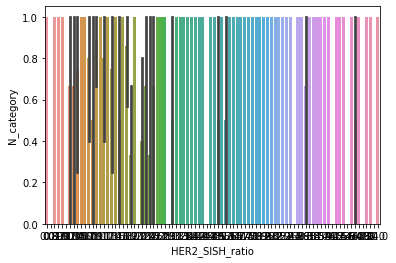

In [109]:
sns.barplot(data=train_csv, x='HER2_SISH_ratio', y='N_category')
plt.show()

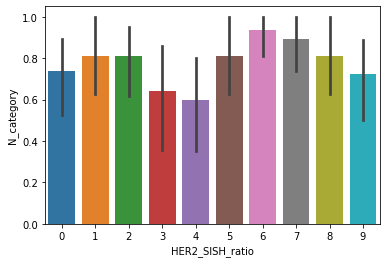

In [123]:
train_csv['HER2_SISH_ratio'] = pd.qcut(train_csv['HER2_SISH_ratio'],q=10, labels=range(10))
sns.barplot(data=train_csv, x='HER2_SISH_ratio', y='N_category')
plt.show()

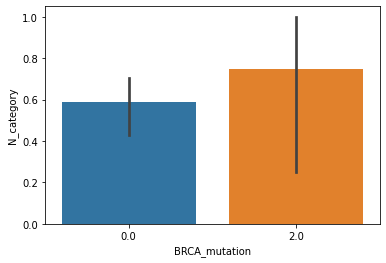

In [124]:
sns.barplot(data=train_csv, x='BRCA_mutation', y='N_category')
plt.show()

In [126]:
train_csv['BRCA_mutation'].fillna(0, inplace=True)
train_csv['BRCA_mutation'].value_counts()

0.0    996
2.0      4
Name: BRCA_mutation, dtype: int64

# feature engeenering

In [174]:
train_csv.head(2)

,ID,img_path,mask_path,나이,수술연월일,진단명,암의 위치,암의 개수,암의 장경,NG,...,ER_Allred_score,PR,PR_Allred_score,KI-67_LI_percent,HER2,HER2_IHC,HER2_SISH,HER2_SISH_ratio,BRCA_mutation,N_category
0,BC_01_0001,/content/train/BC_01_0001.png,-,63,2015-10-23,1,2,1,19.0,2.0,...,8.0,1.0,6.0,12.0,0.0,1.0,NaN,NaN,NaN,0
1,BC_01_0002,/content/train/BC_01_0002.png,-,51,2015-10-28,1,1,1,22.0,3.0,...,NaN,0.0,NaN,70.0,0.0,0.0,NaN,NaN,NaN,1


In [175]:
train_csv['나이'] = pd.cut(train_csv['나이'], bins=10, labels=range(10))
train_csv['나이'] =train_csv['나이'].astype('int64')

In [176]:
train_csv['수술연월일'] = pd.to_datetime(train_csv['수술연월일'])
def deltamonth(x):
    return (pd.to_datetime('2020-07-01') - x).days // 365
train_csv['수술경과년'] = train_csv['수술연월일'].apply(deltamonth)

In [177]:
train_csv = pd.get_dummies(train_csv, columns=['진단명'])

In [178]:
train_csv['암의 장경'].fillna(0, inplace=True)
train_csv['암의 장경'] = pd.cut(train_csv['암의 장경'], bins=10, labels=range(10))
def up5(x):
    if x >= 5:
        x = 5
    return x
train_csv['암의 장경'] = train_csv['암의 장경'].apply(up5)

In [179]:
train_csv['NG'].fillna(1, inplace=True)

In [180]:
train_csv['HG'].fillna(0, inplace=True)

In [181]:
train_csv['HG_score_1'].fillna(0, inplace=True)

In [182]:
train_csv['HG_score_2'].fillna(0, inplace=True)

In [183]:
train_csv['HG_score_3'].fillna(0, inplace=True)
def HG_score_3_4(x):
    if x == 4:
        x = 0
    return x
train_csv['HG_score_3'] = train_csv['HG_score_3'].apply(HG_score_3_4)

In [184]:
train_csv = pd.get_dummies(train_csv, columns=['DCIS_or_LCIS_여부'])

In [185]:
train_csv['T_category'].fillna(4, inplace=True)

In [186]:
train_csv.columns

Index(['ID', 'img_path', 'mask_path', '나이', '수술연월일', '암의 위치', '암의 개수', '암의 장경',
       'NG', 'HG', 'HG_score_1', 'HG_score_2', 'HG_score_3',
       'DCIS_or_LCIS_type', 'T_category', 'ER', 'ER_Allred_score', 'PR',
       'PR_Allred_score', 'KI-67_LI_percent', 'HER2', 'HER2_IHC', 'HER2_SISH',
       'HER2_SISH_ratio', 'BRCA_mutation', 'N_category', '수술경과년', '진단명_1',
       '진단명_2', '진단명_3', '진단명_4', 'DCIS_or_LCIS_여부_0', 'DCIS_or_LCIS_여부_1',
       'DCIS_or_LCIS_여부_2'],
      dtype='object')

In [187]:
train_csv = train_csv.drop(['ID', '수술연월일', '암의 위치', 'DCIS_or_LCIS_type', 'ER', 'ER_Allred_score', 'PR',
       'PR_Allred_score', 'KI-67_LI_percent', 'HER2', 'HER2_IHC', 'HER2_SISH',
       'HER2_SISH_ratio', 'BRCA_mutation'], axis=1)

In [188]:
train_csv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   img_path           1000 non-null   object 
 1   mask_path          1000 non-null   object 
 2   나이                 1000 non-null   int64  
 3   암의 개수              1000 non-null   int64  
 4   암의 장경              1000 non-null   int64  
 5   NG                 1000 non-null   float64
 6   HG                 1000 non-null   float64
 7   HG_score_1         1000 non-null   float64
 8   HG_score_2         1000 non-null   float64
 9   HG_score_3         1000 non-null   float64
 10  T_category         1000 non-null   float64
 11  N_category         1000 non-null   int64  
 12  수술경과년              1000 non-null   int64  
 13  진단명_1              1000 non-null   uint8  
 14  진단명_2              1000 non-null   uint8  
 15  진단명_3              1000 non-null   uint8  
 16  진단명_4              1000 n

# model select(df)

In [189]:
x_train = train_csv.copy()
y_train = x_train.pop('N_category') 
x_train = x_train.drop(['img_path', 'mask_path'], axis=1)

In [197]:
x_ttrain, x_ttest, y_ttrain, y_ttest = train_test_split(x_train, y_train, stratify=y_train, test_size=0.1)

In [198]:
xgb = XGBRFClassifier()
lgb = LGBMClassifier()
svc = SVC()
knc = KNeighborsClassifier()
rfc = RandomForestClassifier()
cat = CatBoostClassifier(verbose=0)
models = [xgb, lgb, svc, knc, rfc, cat]
for i in models:
    model = i.fit(x_ttrain, y_ttrain)
    sc = round(model.score(x_ttrain, y_ttrain),2)
    pre = model.predict(x_ttest)
    f1 = round(f1_score(y_ttest, pre, average='macro'), 2)
    print(f'model : {i.__class__.__name__}, sc : {sc}, f1 : {f1}')

model : XGBRFClassifier, sc : 0.8, f1 : 0.8
model : LGBMClassifier, sc : 0.93, f1 : 0.84
model : SVC, sc : 0.8, f1 : 0.81
model : KNeighborsClassifier, sc : 0.83, f1 : 0.81
model : RandomForestClassifier, sc : 0.98, f1 : 0.79
model : CatBoostClassifier, sc : 0.91, f1 : 0.82


# DNN

In [201]:
path, label = train_csv['img_path'], train_csv['N_category']
train_path, val_path, train_label, val_label = train_test_split(path, label, stratify=label, test_size=0.1)

In [206]:
class data_loder(tf.keras.utils.Sequence):
    def __init__(self, path, label=None, img_size=500, batch_size= 32, shuffle=False, argument=False):
        self.path = path
        self.label = label
        self.img_size = img_size
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.argument = argument

        if self.shuffle:
            self.on_epoch_end()

    def __len__(self):
        return len(self.path) // self.batch_size

    def __getitem__(self, idx):
        path_index

    def on_epoch_end(self):
        if self.shuffle:
            self.path, self.label = sklearn.utils.shuffle(self.path, self.label)


In [207]:
train_ds = data_loder(train_path)
len(train_ds)

28